In [19]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import secrets
import datetime

In [693]:
# Create an EV class with the following attributes:
# - Brand
# - Model
# - Battery type
# - Battery size
# - Charging Efficiency
# - Discharging Efficiency
# - Energy per km
# - SOC min
# - SOC max
# - Probability in population - this is the probability that a car of this type will be chosen from the population

class EV:
    def __init__(self, brand, model, battery_type, battery_size, charging_efficiency, discharging_efficiency, energy_per_km, soc_min, soc_max, probability_in_population, charging_probabilities=None):
        self.brand = brand
        self.model = model
        self.battery_type = battery_type
        self.battery_size = battery_size
        self.charging_efficiency = charging_efficiency if charging_efficiency <= 1 or charging_efficiency >= 0 else 0.9
        self.discharging_efficiency = discharging_efficiency if discharging_efficiency <= 1 or discharging_efficiency >= 0 else 0.9
        self.energy_per_km = energy_per_km
        self.soc_min = soc_min if soc_min >= 0.0 else 0.0
        self.soc_max = soc_max if soc_max <= 1.0 else 1.0
        self.probability_in_population = probability_in_population if probability_in_population <= 1.0 else 1.0

        # Set charging probabilities or attribute values if None
        if charging_probabilities is not None:
            self.charging_probabilities = charging_probabilities
        else:
            self.charging_probabilities = {"Fast": 0.5, "Slow": 0.5}

        # Attribute a charging type according to the probabilities in the charging_probabilities dictionary
        self.charging_type = np.random.choice(list(self.charging_probabilities.keys()), p=list(self.charging_probabilities.values()))


# Extend the class to create drivable EVs
class DrivableEV(EV):

    # __init__ method is inherited from EV class, extended with the state of charge. Creates the following attributes:
    # - State of Charge
    # - List of trips
    # - Current trip
    def __init__(self, brand, model, battery_type, battery_size, charging_efficiency, discharging_efficiency, energy_per_km, soc_min, soc_max, probability_in_population, charging_stations, initial_soc=None, stopping_soc=None, charging_probabilities=None):
        super().__init__(brand, model, battery_type, battery_size, charging_efficiency, discharging_efficiency, energy_per_km, soc_min, soc_max, probability_in_population, charging_probabilities)

        # EV ID
        self.ev_id = secrets.token_hex(16)

        # SOC variables
        self.soc = [initial_soc]
        self.current_soc = initial_soc
        # Attribute a random SOC to stop the EV if none is provided
        self.stopping_soc = stopping_soc if stopping_soc is not None else np.random.uniform(0.2, 0.3, 1)[0]

        # List of trips and current trip
        self.trips = []
        self.split_trips = []

        # Information about the charging stations
        self.charging_stations = charging_stations

        # Create a pool of possible charging stations according to EV charging type
        self.default_charging_stations_pool = [charging_station for charging_station in self.charging_stations if
                                               charging_station.charging_station_type == self.charging_type]

        self.segment_charging_station_pool = [charging_station for charging_station in self.charging_stations if
                                              charging_station.charging_station_type == 'Fast']

        # Attribute a default charging station from the pool and attribute the EV ID to it
        self.default_charging_station = np.random.choice(self.default_charging_stations_pool, 1)[0]
        self.default_charging_station.ev_id = self.ev_id

        # Attribute a random Fast charging station
        self.segment_charging_station = np.random.choice(self.segment_charging_station_pool, 1)[0]
        self.segment_charging_station.ev_id = self.ev_id

        # Create a list of charging stations
        self.charging_stations_list = [self.default_charging_station, self.segment_charging_station]

        # Number of stops
        self.number_of_stops = 0


    # Format the print
    def __repr__(self):
        return f"{self.brand} {self.model} with {self.battery_size} kWh battery"

    # Create a method to add a trip to the EV
    def add_trip(self, trip):
        self.trips.append(trip)


    # Create a method to charge the EV
    def charge(self, charge_amount):
        self.current_soc += charge_amount * self.charging_efficiency

        if self.current_soc > 1.0:
            self.current_soc = 1.0

        self.soc.append(self.current_soc)


    # Create a method to discharge the EV
    def discharge(self, discharge_amount):
        self.current_soc -= discharge_amount * self.discharging_efficiency

        if self.current_soc < 0:
            self.current_soc = 0

        self.soc.append(self.current_soc)


    # Create a method to split the assigned trips in which the EV SOC is not enough to cover it
    def split_ev_trips(self):
        list_split_trips = []

        # Create new DrivableTrip object based on assigned trips and append to the list:
        # - Check if trip required energy is more than the EV SOC
        # - If yes, segment the trip and calculate the covered trip length, the remaining trip length and the energy required for each until the EV SOC is enough to cover the remaining trip
        # - If no, append the trip to the list
        for trip in self.trips:

            # Check need to split trip
            if trip.trip_required_soc > (self.current_soc - self.stopping_soc):
                # Initialize the covered trip length and remaining trip length
                covered_trip_length = 0
                remaining_trip_length = trip.trip_length

                # Current time for trip start
                current_time = trip.trip_start_time

                # Initialize the energy required for the trip
                energy_required = trip.trip_required_soc

                # Loop to segment the trip until the EV SOC is enough to cover the remaining trip
                while energy_required > (self.current_soc - self.stopping_soc):

                    # Print split trip information
                    print(energy_required, self.current_soc, self.stopping_soc)

                    # Calculate used energy
                    used_energy = (self.current_soc - self.stopping_soc)

                    # Calculate the covered trip length of the current segment
                    current_covered_trip_length = (self.battery_size * used_energy)  / ev.energy_per_km

                    # Check for end of trip
                    if current_covered_trip_length >= remaining_trip_length:
                        current_covered_trip_length = remaining_trip_length
                        used_energy = (current_covered_trip_length * ev.energy_per_km) / self.battery_size

                    # Calculate the covered trip length
                    covered_trip_length += current_covered_trip_length
                    remaining_trip_length -= current_covered_trip_length
                    energy_required -= used_energy
                    self.discharge(used_energy)

                    # Calculate duration of covered distance as datetime
                    covered_trip_duration = current_covered_trip_length / trip.trip_speed
                    covered_trip_duration = datetime.timedelta(hours=covered_trip_duration)

                    # Segment end time
                    trip_end_time = current_time + covered_trip_duration

                    drivable_trip = DrivableTrip(current_covered_trip_length, trip.trip_speed,
                                                 current_time, trip_end_time, covered_trip_duration,
                                                 profile=trip.profile,
                                                 trip_id=trip.trip_id)

                    # Add the EV information to the trip
                    drivable_trip.ev = self
                    drivable_trip.ev_id = self.ev_id
                    drivable_trip.calculate_trip_energy_consumption()
                    drivable_trip.calculate_trip_required_soc()
                    drivable_trip.assign_ev_battery_size()

                    list_split_trips.append(drivable_trip)

                    # Charge the EV until it reaches 0.8 of the battery size
                    self.charge(self.battery_size * 0.8 - self.current_soc)

                    # Update the number of stops
                    self.number_of_stops += 1

                    # Determine the time to charge the EV
                    charge_time = (self.battery_size * 0.8 - self.current_soc) / self.segment_charging_station.charging_station_power * self.segment_charging_station.charging_station_efficiency

                    # Calculate the charge time as datetime
                    charge_time = datetime.timedelta(hours=charge_time)

                    # Calculate the end time of the charge
                    charge_end_time = trip_end_time + charge_time

                    # Update the current time
                    current_time = charge_end_time

                    # Update the charging station history
                    self.segment_charging_station.update_history(trip_end_time, charge_end_time)

                # Charge the EV at the end of trip to 0.8 of the battery size
                self.charge(self.battery_size * 0.8 - self.current_soc)

                # Update the time to charge the EV using the default charging station
                charge_time = (self.battery_size * 0.8 - self.current_soc) / self.default_charging_station.charging_station_power * self.default_charging_station.charging_station_efficiency

                # Update the default charging station history
                self.default_charging_station.update_history(current_time, current_time + datetime.timedelta(hours=charge_time))


            else:
                # Simply add the trip to the list
                list_split_trips.append(trip)

                # Charge the EV at the end of trip to 0.8 of the battery size
                self.charge(self.battery_size * 0.8 - self.current_soc)

                # Update the time to charge the EV using the default charging station
                charge_time = (self.battery_size * 0.8 - self.current_soc) / self.default_charging_station.charging_station_power * self.default_charging_station.charging_station_efficiency

                # Update the time

                # Update the default charging station history
                self.default_charging_station.update_history(trip.trip_end_time, trip.trip_end_time + datetime.timedelta(hours=charge_time))

        # Update the trips list
        self.split_trips = list_split_trips


In [694]:
# Define a Trip class, that will assign a trip to an EV. Has the following parameters:
# - EV
# - Trip length
# - Trip start time (can be a range)
# - Trip end time (can be a range)
# - Trip start SOC
# - Trip end SOC
# - Trip energy consumption
# - Trip stops

class Trip:
    def __init__(self, trip_length, trip_start_time, trip_end_time, trip_duration):
        self.trip_length = trip_length
        self.trip_start_time = trip_start_time
        self.trip_end_time = trip_end_time
        self.trip_duration = trip_duration


class DrivableTrip(Trip):
    # Init method is the same as Trip class
    def __init__(self, trip_length, trip_speed, trip_start_time, trip_end_time, trip_duration, profile=None, trip_id=None):
        super().__init__(trip_length, trip_start_time, trip_end_time, trip_duration)

        # Information about EV
        self.ev = None
        self.ev_id = None

        # Information about the trip
        self.trip_speed = trip_speed
        self.trip_energy_consumption = None
        self.trip_required_soc = None
        self.covered_trip_length = None
        self.ev_battery_size = None
        self.trip_estimate_arrival = trip_end_time
        self.profile = profile

        # Assign a trip ID
        self.trip_id = trip_id if trip_id is not None else secrets.token_hex(16)


    # Formatted print method
    def __repr__(self):
        return f'Trip length: {self.trip_length} km, trip start time: {self.trip_start_time}, ' \
               f'trip end time: {self.trip_end_time}, trip energy consumption: {self.trip_energy_consumption} kWh, ' \
               f'trip required SOC: {self.trip_required_soc} %'

    # Create a method to calculate the trip energy consumption
    def calculate_trip_energy_consumption(self):
        self.trip_energy_consumption = self.trip_length * self.ev.energy_per_km


    # Create a method to calculate the trip required SOC
    def calculate_trip_required_soc(self):
        self.trip_required_soc = self.trip_energy_consumption / self.ev.battery_size


    # Create a method to assign the battery size of the EV to the trip
    def assign_ev_battery_size(self):
        self.ev_battery_size = self.ev.battery_size


    # Create a method to update the covered trip length
    def update_covered_trip_length(self, covered_trip_length):
        self.covered_trip_length += covered_trip_length


    # Create a method to update the required SOC
    def update_trip_required_soc(self):
        self.trip_required_soc = (self.trip_energy_consumption - self.covered_trip_length * self.ev.energy_per_km) / self.ev.battery_size


In [695]:
# Define a Charging Station class, that will charge the EVs. Has the following parameters:
# - Charging station name
# - Charging station location
# - Charging station type
# - Charging station power
# - Charging station efficiency
# - Charging station availability
# - Charging station cost

class ChargingStation:
    def __init__(self, charging_station_type, charging_station_power, charging_station_efficiency, charging_station_cost, charging_station_probability, ev_id=None):
        # Parameters Assign
        self.charging_station_type = charging_station_type
        self.charging_station_power = charging_station_power
        self.charging_station_cost = charging_station_cost
        self.charging_station_efficiency = charging_station_efficiency
        self.charging_station_probability = charging_station_probability

        # Charging station history
        self.charging_station_history = []

        # EV ID
        self.ev_id = ev_id


    # Method to update the charging station history to store the logs
    def update_history(self, start_time, end_time):
        self.charging_station_history.append([start_time, end_time])


In [696]:
# Define a User class, that will have the following parameters:
# - User name
# - User location
# - User trips
# - User EV
# - User type

class User:
    def __init__(self, user_name, user_profile):
        # Parameters Assign
        self.user_name = user_name
        self.user_profile = user_profile

    # Method to assign an EV to the user
    def assign_ev(self, ev):
        self.user_ev = ev


# Create a Profile class that will determine the behaviour of the Users. Has the following parameters:
# - Profile name
# - Profile type
# - Profile trip schedule
# - Trip type
class Profile:
    def __init__(self, profile_name, trip_type, profile_trip_schedule):
        # Parameters Assign
        self.profile_name = profile_name
        self.trip_type = trip_type
        self.profile_trip_schedule = profile_trip_schedule

    # Format printing
    def __repr__(self):
        return f'N:{self.profile_name}, T:{self.trip_type}'


# Create a Schedule class with the following parameters:
# - Schedule start
# - Schedule end
class Schedule:
    def __init__(self, schedule_start):
        # Parameters Assign
        self.schedule_start = schedule_start

    # Format printing
    def __repr__(self):
        return f'Schedule start hours: {self.schedule_start}'

In [717]:
 # Define an Aggregator class, that will aggregate the trips and EVs. Has the following parameters:
# - EVs
# - Number of EVs
class Aggregator:
    def __init__(self, profiles, evs, charging_stations):
        # Profile assign
        self.profiles = profiles

        # Assign the EVs to the aggregator
        self.evs = evs

        # Number of EVs of the simulation
        self.number_of_evs = None

        # Create a list of trips
        self.trips = []
        self.segments = []
        self.population = None
        self.assigned_evs = []

        # Assign the charging stations to the aggregator
        self.charging_stations = charging_stations

    # Add an EV to the fleet
    def add_ev(self, ev):
        self.evs.append(ev)

    # Assign a trip to an EV
    def assign_trip(self, ev, trip):
        ev.add_trip(trip)

    # Assign a charging station to an EV, and charge the EV if:
    # - The charging station is available
    # - The charging station is of the correct type
    # - The charging station has enough power to charge the EV
    def assign_charging_station(self, ev, charging_station):
        if charging_station.charging_station_availability == True and charging_station.charging_station_type == ev.battery_type and charging_station.charging_station_power >= ev.battery_size:
            ev.current_charging_station = charging_station
            ev.charge(charging_station.charging_station_power)
            charging_station.charging_station_availability = False


    # Create the population of DrivableEVs according to NumPy's random.choice
    def create_evs(self, n_evs):
        # Assign the number of EVs to the aggregator
        self.number_of_evs = n_evs

        # Create an EV population according to the given probabilities of the EVs
        population_choice = np.random.choice(self.evs, n_evs,
                                             p=[ev.probability_in_population for ev in self.evs])

        # Create a list of DrivableEVs
        self.population = [DrivableEV(ev.brand, ev.model, ev.battery_type, ev.battery_size,
                                      ev.charging_efficiency, ev.discharging_efficiency,
                                      ev.energy_per_km, ev.soc_min, ev.soc_max,
                                      ev.probability_in_population,
                                      self.charging_stations,
                                      initial_soc=np.round(np.random.uniform(ev.soc_min,
                                                                             ev.soc_max, 1)[0], 2))
                           for ev in population_choice]


    # Create DrivableTrips with gamma distribution for the trip length
    # Create a gamma distribution for the trip length
    def create_trips(self, n_trips, time_resolution=1, avg_speed_short=60, avg_speed_medium=80, avg_speed_long=100, medium_trip_min=50, medium_trip_max=100, trip_start_variation=1.0, avg_speed_variation=1.0):
        shape, scale = 46.*.01, 46.*2
        trip_lengths = np.round(np.random.gamma(shape, scale, n_trips), 2)

        # Assign the trip lengths to the trips list
        self.trips = [Trip(trip_length, None, None, None) for trip_length in trip_lengths]

        # Create the DrivableTrips
        for trip in range(n_trips):

            # Calculate trip type based on distance
            trip_type = 'Short' if trip_lengths[trip] <= medium_trip_min else 'Medium' if medium_trip_min < trip_lengths[trip] <= medium_trip_max else 'Long'

            # Calculate average speed based on trip type
            avg_speed = avg_speed_short if trip_type == 'Short' else avg_speed_medium if trip_type == 'Medium' else avg_speed_long

            # Get the user profiles that match the trip type
            user_profiles = [profile for profile in self.profiles if profile.trip_type == trip_type]

            # Get the user profile based on the user profiles that match the trip type
            user_profile = np.random.choice(user_profiles, 1)[0]

            # Check how many trips the user has
            user_trips = len(user_profile.profile_trip_schedule.schedule_start)

            # If there are more than 1 trip, split into multiple trips
            if user_trips > 1:

                # Placeholder for list of segments of each trip. Each segment is a DrivableTrip
                segment_list = []

                # Calculate the required socs for trip segment
                for i in range(user_trips):
                    # Get a random start centered around schedule start
                    segment_start = np.random.uniform(user_profile.profile_trip_schedule.schedule_start[i] - trip_start_variation,
                                                      user_profile.profile_trip_schedule.schedule_start[i] + trip_start_variation, 1)[0]

                    # Get a random average speed centered on avg_speed with variation
                    segment_avg_speed = np.random.uniform(avg_speed - avg_speed_variation, avg_speed + avg_speed_variation, 1)[0] * time_resolution

                    # Calculate the segment end
                    segment_end = segment_start + trip_lengths[trip] / segment_avg_speed

                    # Calculate the segment length
                    duration = segment_end - segment_start if segment_end > segment_start else 0

                    # Convert float values to timestamp
                    segment_start = datetime.datetime(2023, 1, 1, int(segment_start), int((segment_start - int(segment_start)) * 60))
                    segment_end = datetime.datetime(2023, 1, 1, int(segment_end), int((segment_end - int(segment_end)) * 60))
                    duration = datetime.datetime(2023, 1, 1, int(duration), int((duration - int(duration)) * 60))

                    # Create a DrivableTrip for each segment
                    segment_list.append(DrivableTrip(trip_lengths[trip] / user_trips,
                                                     segment_avg_speed,
                                                     segment_start, segment_end,
                                                     duration, profile=user_profile))

                # Append to the trips list
                self.segments.append(segment_list)

            elif user_trips == 1:

                # Get a random start centered around schedule start
                segment_start = np.random.uniform(user_profile.profile_trip_schedule.schedule_start[0] - trip_start_variation,
                                                  user_profile.profile_trip_schedule.schedule_start[0] + trip_start_variation, 1)[0]

                # Get a random average speed centered on avg_speed with variation
                segment_avg_speed = np.random.uniform(avg_speed - avg_speed_variation, avg_speed + avg_speed_variation, 1)[0] * time_resolution

                # Calculate the segment end
                segment_end = segment_start + trip_lengths[trip] / segment_avg_speed

                # Calculate the segment length
                duration = segment_end - segment_start if segment_end > segment_start else 0

                # Convert float values to time
                segment_start = datetime.datetime(2023, 1, 1, int(segment_start), int((segment_start - int(segment_start)) * 60))
                segment_end = datetime.datetime(2023, 1, 1, int(segment_end), int((segment_end - int(segment_end)) * 60))
                duration = datetime.datetime(2023, 1, 1, int(duration), int((duration - int(duration)) * 60))

                # Create a DrivableTrip for the trip
                drivable_trip = DrivableTrip(trip_lengths[trip],
                                             segment_avg_speed,
                                             segment_start, segment_end,
                                             duration, profile=user_profile)

                # Append to the segments list
                self.segments.append([drivable_trip])


    # Assign the larger trips to the EVs with larger battery sizes with a greater probability
    def assign_trips(self):
        # Create a copy of the population
        population_copy = copy.deepcopy(self.population)
        segments_copy = copy.deepcopy(self.segments)

        # Assigned EVs and Trips
        assigned_evs = []

        # Create a list with the probabilities of the EVs to get a trip
        probabilities = [ev.battery_size / sum([ev.battery_size for ev in self.population]) for ev in population_copy]

        # Sort the segments by trip length and assign it to a temporary variable
        sorted_segments = sorted(segments_copy, key=lambda x: x[0].trip_length, reverse=True)

        # Assign the sorted trips to the EVs
        for segment in sorted_segments:
            # Choose an EV from the population
            ev = np.random.choice(population_copy, 1, p=probabilities)[0]

            for trip in segment:
                # Assign the trip segments to the EV
                trip.ev = ev
                trip.ev_id = ev.ev_id
                trip.calculate_trip_energy_consumption()
                trip.calculate_trip_required_soc()
                trip.assign_ev_battery_size()

                # Add the trip to the EV
                ev.add_trip(trip)

                # Calculate the trip energy consumption and required SOC
                trip.calculate_trip_energy_consumption()
                trip.calculate_trip_required_soc()

            # Split the trip into segments
            ev.split_ev_trips()

            # Remove the EV from the population
            population_copy.remove(ev)

            self.assigned_evs.append(ev)

            # Recalculate the probabilities
            probabilities = [ev.battery_size / sum([ev.battery_size for ev in population_copy]) for ev in population_copy]

            # If the population is empty, break the loop
            if len(population_copy) == 0:
                break


    # Create a DataFrame of the population
    def population_dataframe(self):
        # Create a DataFrame of the population
        population_dataframe = pd.DataFrame([ev.__dict__ for ev in self.population])

        # Return the DataFrame
        return population_dataframe


    # Create a DataFrame of assigned EVs
    def assigned_evs_dataframe(self):
        # Create a DataFrame of the population
        assigned_evs_dataframe = pd.DataFrame([ev.__dict__ for ev in self.assigned_evs])

        # Return the DataFrame
        return assigned_evs_dataframe


    # Create a DataFrame of the trips
    def assigned_trips_dataframe(self):
        # Create a DataFrame of the trips
        trips_dataframe = pd.DataFrame([trip.trip_length for trip in self.trips])
        trips_dataframe.columns = ["trip_length"]

        # Return the DataFrame
        return trips_dataframe


    # Create a DataFrame of assigned Trips and all the information in the list
    def assigned_segments_dataframe(self):
        # Create a DataFrame of the population
        assigned_trips_dataframe = pd.DataFrame([trip.__dict__ for ev in self.assigned_evs for trip in ev.trips])

        # Return the DataFrame
        return assigned_trips_dataframe

    # Create a DataFrame of the EVs' split trips
    def assigned_split_trips_dataframe(self):
        # Create a DataFrame of the population
        assigned_split_trips_dataframe = pd.DataFrame([trip.__dict__ for ev in self.assigned_evs for trip in ev.split_trips])

        # Return the DataFrame
        return assigned_split_trips_dataframe


    # Create a DataFrame of the charging stations used by the EVs
    def assigned_cs_dataframe(self):
        # Create a DataFrame of the population
        assigned_cs_dataframe = pd.DataFrame([cs.__dict__ for ev in self.assigned_evs for cs in ev.charging_stations_list])

        # Return the DataFrame
        return assigned_cs_dataframe

In [718]:
# Create a list of EVs to use in the simulation

EVs = [EV(brand='Nissan', model='Leaf', battery_type='BEV', battery_size=59,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.16, energy_per_km=0.17, soc_min=0.7, soc_max=1.0,
          charging_probabilities={'Slow': 0.5, 'Fast': 0.5}),
       EV(brand='Tesla', model='Model 3', battery_type='BEV', battery_size=95,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.13, energy_per_km=0.18, soc_min=0.7, soc_max=1.0,
          charging_probabilities={'Slow': 0.5, 'Fast': 0.5}),
       EV(brand='Peugeot', model='e-Expert', battery_type='BEV', battery_size=68,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.1, energy_per_km=0.26, soc_min=0.7, soc_max=1.0,
          charging_probabilities={'Slow': 0.5, 'Fast': 0.5}),
       EV(brand='Renault', model='Zoe', battery_type='BEV', battery_size=52,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.1, energy_per_km=0.17, soc_min=0.7, soc_max=1.0,
          charging_probabilities={'Slow': 0.5, 'Fast': 0.5}),
       EV(brand='Jaguar', model='I-Pace', battery_type='BEV', battery_size=85,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.09, energy_per_km=0.22, soc_min=0.7, soc_max=1.0,
          charging_probabilities={'Slow': 0.5, 'Fast': 0.5}),
       EV(brand='Mercedes', model='E300', battery_type='PHEV', battery_size=13.5,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.08, energy_per_km=0.18, soc_min=0.7, soc_max=1.0,
          charging_probabilities={'Slow': 0.5, 'Fast': 0.5}),
       EV(brand='BMW', model='530e', battery_type='PHEV', battery_size=70.2,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.08, energy_per_km=0.16, soc_min=0.7, soc_max=1.0,
          charging_probabilities={'Slow': 0.5, 'Fast': 0.5}),
       EV(brand='Audi Q4', model='e-tron', battery_type='PHEV', battery_size=55,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.07, energy_per_km=0.17, soc_min=0.7, soc_max=1.0,
          charging_probabilities={'Slow': 0.5, 'Fast': 0.5}),
       EV(brand='Hyundai', model='Kauai', battery_type='BEV', battery_size=74,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.06, energy_per_km=0.192, soc_min=0.7, soc_max=1.0,
          charging_probabilities={'Slow': 0.5, 'Fast': 0.5}),
       EV(brand='Volvo', model='XC40', battery_type='PHEV', battery_size=78,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.05, energy_per_km=0.176, soc_min=0.7, soc_max=1.0,
          charging_probabilities={'Slow': 0.5, 'Fast': 0.5}),
       EV(brand='Wolkswagen', model='ID.3', battery_type='PHEV', battery_size=58,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.05, energy_per_km=0.155, soc_min=0.7, soc_max=1.0,
          charging_probabilities={'Slow': 0.5, 'Fast': 0.5}),
       EV(brand='Others', model='Others', battery_type='PEV', battery_size=20,
          charging_efficiency=0.9, discharging_efficiency=0.9,
          probability_in_population=0.03, energy_per_km=0.2, soc_min=0.7, soc_max=1.0,
          charging_probabilities={'Slow': 0.5, 'Fast': 0.5})]

# Print the sum of the probabilities in the population of EVs
sum_of_probabilities = 0
for ev in EVs:
    sum_of_probabilities += ev.probability_in_population
print(sum_of_probabilities)

1.0


In [719]:
# Create a list of Charging Stations to use in the simulation

CS = [ChargingStation(charging_station_type='Slow',
                      charging_station_power=3.6,
                      charging_station_efficiency=0.9,
                      charging_station_cost=0.15,
                      charging_station_probability=0.25),
      ChargingStation(charging_station_type='Slow',
                      charging_station_power=7.2,
                      charging_station_efficiency=0.9,
                      charging_station_cost=0.15,
                      charging_station_probability=0.25),
      ChargingStation(charging_station_type='Fast',
                      charging_station_power=3.6,
                      charging_station_efficiency=0.9,
                      charging_station_cost=0.15,
                      charging_station_probability=0.25),
      ChargingStation(charging_station_type='Fast',
                      charging_station_power=7.2,
                      charging_station_efficiency=0.9,
                      charging_station_cost=0.15,
                      charging_station_probability=0.25)]

In [720]:
# Create the profiles to use in the simulation

# Create a list of profiles
PROFILES = [Profile(profile_name='Residential', profile_trip_schedule=Schedule([8, 16]), trip_type='Short'),
            Profile(profile_name='Residential', profile_trip_schedule=Schedule([5, 18]), trip_type='Medium'),
            Profile(profile_name='Shopping', profile_trip_schedule=Schedule([8, 18]), trip_type='Short'),
            Profile(profile_name='Work', profile_trip_schedule=Schedule([8]), trip_type='Long')]

In [721]:
# Create an Aggregator object
aggregator = Aggregator(profiles=PROFILES, evs=EVs, charging_stations=CS)

# Create the population of EVs
aggregator.create_evs(n_evs=100)

# Create the trips
aggregator.create_trips(n_trips=100,
                        avg_speed_short=60,
                        avg_speed_medium=80,
                        avg_speed_long=100)

# Assign the EVs to the trips and calculate the trip energy consumption and required SOC.
# Also, assign the trip to the EV
aggregator.assign_trips()

0.5472 0.77 0.2541154525272495


In [722]:
# Print the population
aggregator.population_dataframe()

,brand,model,battery_type,battery_size,charging_efficiency,discharging_efficiency,energy_per_km,soc_min,soc_max,probability_in_population,...,stopping_soc,trips,split_trips,charging_stations,default_charging_stations_pool,segment_charging_station_pool,default_charging_station,segment_charging_station,charging_stations_list,number_of_stops
0,Nissan,Leaf,BEV,59.0,0.9,0.9,0.170,0.7,1.0,0.16,...,0.272700,[],[],[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,<__main__.ChargingStation object at 0x000001E3...,<__main__.ChargingStation object at 0x000001E3...,[<__main__.ChargingStation object at 0x000001E...,0
1,Renault,Zoe,BEV,52.0,0.9,0.9,0.170,0.7,1.0,0.10,...,0.288073,[],[],[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,<__main__.ChargingStation object at 0x000001E3...,<__main__.ChargingStation object at 0x000001E3...,[<__main__.ChargingStation object at 0x000001E...,0
2,Wolkswagen,ID.3,PHEV,58.0,0.9,0.9,0.155,0.7,1.0,0.05,...,0.215788,[],[],[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,<__main__.ChargingStation object at 0x000001E3...,<__main__.ChargingStation object at 0x000001E3...,[<__main__.ChargingStation object at 0x000001E...,0
3,Volvo,XC40,PHEV,78.0,0.9,0.9,0.176,0.7,1.0,0.05,...,0.273290,[],[],[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,<__main__.ChargingStation object at 0x000001E3...,<__main__.ChargingStation object at 0x000001E3...,[<__main__.ChargingStation object at 0x000001E...,0
4,Mercedes,E300,PHEV,13.5,0.9,0.9,0.180,0.7,1.0,0.08,...,0.253923,[],[],[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,<__main__.ChargingStation object at 0x000001E3...,<__main__.ChargingStation object at 0x000001E3...,[<__main__.ChargingStation object at 0x000001E...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Tesla,Model 3,BEV,95.0,0.9,0.9,0.180,0.7,1.0,0.13,...,0.205504,[],[],[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,<__main__.ChargingStation object at 0x000001E3...,<__main__.ChargingStation object at 0x000001E3...,[<__main__.ChargingStation object at 0x000001E...,0
96,BMW,530e,PHEV,70.2,0.9,0.9,0.160,0.7,1.0,0.08,...,0.298398,[],[],[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,<__main__.ChargingStation object at 0x000001E3...,<__main__.ChargingStation object at 0x000001E3...,[<__main__.ChargingStation object at 0x000001E...,0
97,Nissan,Leaf,BEV,59.0,0.9,0.9,0.170,0.7,1.0,0.16,...,0.269275,[],[],[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,<__main__.ChargingStation object at 0x000001E3...,<__main__.ChargingStation object at 0x000001E3...,[<__main__.ChargingStation object at 0x000001E...,0
98,Jaguar,I-Pace,BEV,85.0,0.9,0.9,0.220,0.7,1.0,0.09,...,0.241344,[],[],[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,<__main__.ChargingStation object at 0x000001E3...,<__main__.ChargingStation object at 0x000001E3...,[<__main__.ChargingStation object at 0x000001E...,0


In [723]:
# Print the assigned EVs

aggregator.assigned_evs_dataframe()

,brand,model,battery_type,battery_size,charging_efficiency,discharging_efficiency,energy_per_km,soc_min,soc_max,probability_in_population,...,stopping_soc,trips,split_trips,charging_stations,default_charging_stations_pool,segment_charging_station_pool,default_charging_station,segment_charging_station,charging_stations_list,number_of_stops
0,Tesla,Model 3,BEV,95.0,0.9,0.9,0.180,0.7,1.0,0.13,...,0.254115,"[Trip length: 288.8 km, trip start time: 2023-...","[Trip length: 245.04516004955647 km, trip star...",[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,<__main__.ChargingStation object at 0x000001E3...,<__main__.ChargingStation object at 0x000001E3...,[<__main__.ChargingStation object at 0x000001E...,1
1,Tesla,Model 3,BEV,95.0,0.9,0.9,0.180,0.7,1.0,0.13,...,0.276466,"[Trip length: 265.66 km, trip start time: 2023...","[Trip length: 265.66 km, trip start time: 2023...",[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,<__main__.ChargingStation object at 0x000001E3...,<__main__.ChargingStation object at 0x000001E3...,[<__main__.ChargingStation object at 0x000001E...,0
2,Tesla,Model 3,BEV,95.0,0.9,0.9,0.180,0.7,1.0,0.13,...,0.242340,"[Trip length: 249.47 km, trip start time: 2023...","[Trip length: 249.47 km, trip start time: 2023...",[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,<__main__.ChargingStation object at 0x000001E3...,<__main__.ChargingStation object at 0x000001E3...,[<__main__.ChargingStation object at 0x000001E...,0
3,Wolkswagen,ID.3,PHEV,58.0,0.9,0.9,0.155,0.7,1.0,0.05,...,0.215788,"[Trip length: 158.82 km, trip start time: 2023...","[Trip length: 158.82 km, trip start time: 2023...",[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,<__main__.ChargingStation object at 0x000001E3...,<__main__.ChargingStation object at 0x000001E3...,[<__main__.ChargingStation object at 0x000001E...,0
4,Tesla,Model 3,BEV,95.0,0.9,0.9,0.180,0.7,1.0,0.13,...,0.269901,"[Trip length: 147.49 km, trip start time: 2023...","[Trip length: 147.49 km, trip start time: 2023...",[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,<__main__.ChargingStation object at 0x000001E3...,<__main__.ChargingStation object at 0x000001E3...,[<__main__.ChargingStation object at 0x000001E...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Others,Others,PEV,20.0,0.9,0.9,0.200,0.7,1.0,0.03,...,0.263191,"[Trip length: 0.025 km, trip start time: 2023-...","[Trip length: 0.025 km, trip start time: 2023-...",[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,<__main__.ChargingStation object at 0x000001E3...,<__main__.ChargingStation object at 0x000001E3...,[<__main__.ChargingStation object at 0x000001E...,0
96,Mercedes,E300,PHEV,13.5,0.9,0.9,0.180,0.7,1.0,0.08,...,0.253923,"[Trip length: 0.01 km, trip start time: 2023-0...","[Trip length: 0.01 km, trip start time: 2023-0...",[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001E...,<__main__.ChargingStation object at 0x000001E3...,<__main__.ChargingStation object at 0x000001E3...,[<__main__.ChargingStation object at 0x000001E...,0
97,Wolkswagen,ID.3,PHEV,58.0,0.9,0.9,0.155,0.7,1.0,0.05,...,0.231898,"[Trip length: 0.0 km, trip start time: 2023-01...","[Trip length: 0.0 km, trip start time: 2023-01...",[<__main__.ChargingStation object at 0x000001E...,[<__main__.ChargingStation object at 0x000001

In [724]:
# Print the trips

aggregator.assigned_trips_dataframe()

,trip_length
0,38.01
1,10.78
2,11.61
3,37.53
4,9.19
...,...
95,136.42
96,1.90
97,5.96
98,1.48


In [725]:
# Print trip segments

aggregator.assigned_segments_dataframe()

,trip_length,trip_start_time,trip_end_time,trip_duration,ev,ev_id,trip_speed,trip_energy_consumption,trip_required_soc,covered_trip_length,ev_battery_size,trip_estimate_arrival,profile,trip_id
0,288.80,2023-01-01 08:46:00,2023-01-01 11:39:00,2023-01-01 02:52:00,Tesla Model 3 with 95 kWh battery,15de8a9ee3f4cca6af8117b234bdc704,100.436350,51.9840,0.547200,None,95.0,2023-01-01 11:39:00,"N:Work, T:Long",1c0ed94acddebe37f590a5afa9db7afb
1,265.66,2023-01-01 07:01:00,2023-01-01 09:41:00,2023-01-01 02:40:00,Tesla Model 3 with 95 kWh battery,0ca6bb5c3218d26459b49db3e53e0a20,99.294981,47.8188,0.503356,None,95.0,2023-01-01 09:41:00,"N:Work, T:Long",02071c0ca351e8957bd8101b059757a2
2,249.47,2023-01-01 07:21:00,2023-01-01 09:51:00,2023-01-01 02:30:00,Tesla Model 3 with 95 kWh battery,e99db3cfa83d9a10ea53e69ae97c8a2d,99.704717,44.9046,0.472680,None,95.0,2023-01-01 09:51:00,"N:Work, T:Long",4f5e22b078b142a085e82edb554ba58e
3,158.82,2023-01-01 08:44:00,2023-01-01 10:20:00,2023-01-01 01:35:00,Wolkswagen ID.3 with 58 kWh battery,e5f879e743dfa147cbfe6d54495494f1,99.898553,24.6171,0.424433,None,58.0,2023-01-01 10:20:00,"N:Work, T:Long",7c67fd4beca243abd5b3b555fa10e738
4,147.49,2023-01-01 07:04:00,2023-01-01 08:33:00,2023-01-01 01:28:00,Tesla Model 3 with 95 kWh battery,db86a93790c86d4d9d27bddd98505adc,99.881728,26.5482,0.279455,None,95.0,2023-01-01 08:33:00,"N:Work, T:Long",2ba14f535c85640bfdd1bef9c69ba2fb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,0.00,2023-01-01 18:55:00,2023-01-01 18:55:00,2023-01-01 00:00:00,Wolkswagen ID.3 with 58 kWh battery,2b14be9f109066a76809425f7f9d6a5c,59.317280,0.0000,0.000000,None,58.0,2023-01-01 18:55:00,"N:Shopping, T:Short",ee4081231099600235808fdc17be0f80
184,0.00,2023-01-01 07:21:00,2023-01-01 07:21:00,2023-01-01 00:00:00,Mercedes E300 with 13.5 kWh battery,f47ca18a8fc1b47718ea43894006d279,60.822007,0.0000,0.000000,None,13.5,2023-01-01 07:21:00,"N:Residential, T:Short",68b89722933131e089bc2c1a476a9fc0
185,0.00,2023-01-01 16:46:00,2023-01-01 16:46:00,2023-01-01 00:00:00,Mercedes E300 with 13.5 kWh battery,f47ca18a8fc1b47718ea43894006d279,59.767463,0.0000,0.000000,None,13.5,2023-01-01 16:46:00,"N:Residential, T:Short",a5094cc9bc197237c5bb7537c80508f2
186,0.00,2023-01-01 08:00:00,2023-01-01 08:00:00,2023-01-01 00:00:00,Mercedes E300 with 13.5 kWh battery,a59800298887c996664c31137ad815f9,60.724107,0.0000,0.000000,None,13.5,2023-01-01 08:00:00,"N:Shopping, T:Short",bba1e59652f0942e96aa04a5fe426239


In [726]:
# Check trip stops of EVs

aggregator.assigned_split_trips_dataframe()

AttributeError: 'Series' object has no attribute 'time'

In [727]:
# Dataframe of the used Charging Stations

aggregator.assigned_cs_dataframe()

,charging_station_type,charging_station_power,charging_station_cost,charging_station_efficiency,charging_station_probability,charging_station_history,ev_id
0,Fast,7.2,0.15,0.9,0.25,"[[2023-01-02 05:57:23.299826, 2023-01-02 15:19...",964e217deddad17ad899e225449e37c6
1,Fast,3.6,0.15,0.9,0.25,"[[2023-01-01 11:12:23.299826, 2023-01-02 05:57...",c420a2190a3dad0a1f94965bc25f8320
2,Fast,7.2,0.15,0.9,0.25,"[[2023-01-02 05:57:23.299826, 2023-01-02 15:19...",964e217deddad17ad899e225449e37c6
3,Fast,7.2,0.15,0.9,0.25,"[[2023-01-02 05:57:23.299826, 2023-01-02 15:19...",964e217deddad17ad899e225449e37c6
4,Slow,7.2,0.15,0.9,0.25,"[[2023-01-01 09:51:00, 2023-01-01 19:13:30], [...",964e217deddad17ad899e225449e37c6
...,...,...,...,...,...,...,...
195,Fast,3.6,0.15,0.9,0.25,"[[2023-01-01 11:12:23.299826, 2023-01-02 05:57...",c420a2190a3dad0a1f94965bc25f8320
196,Fast,7.2,0.15,0.9,0.25,"[[2023-01-02 05:57:23.299826, 2023-01-02 15:19...",964e217deddad17ad899e225449e37c6
197,Fast,7.2,0.15,0.9,0.25,"[[2023-01-02 05:57:23.299826, 2023-01-02 15:19...",964e217deddad17ad899e225449e37c6
198,Fast,7.2,0.15,0.9,0.25,"[[2023-01-02 05:57:23.299826, 2023-01-02 15:19...",964e217deddad17ad899e225449e37c6


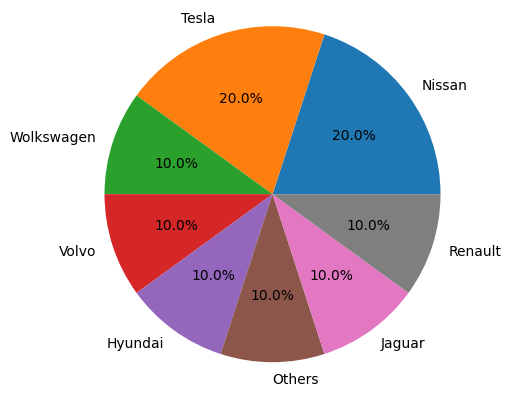

In [670]:
# Plot the population brand in a pie chart

# Values of each group
brand_values = aggregator.population_dataframe()['brand'].value_counts()
plt.pie(brand_values, labels=brand_values.index, autopct='%1.1f%%')

# View the plot
plt.axis('equal')
plt.show()

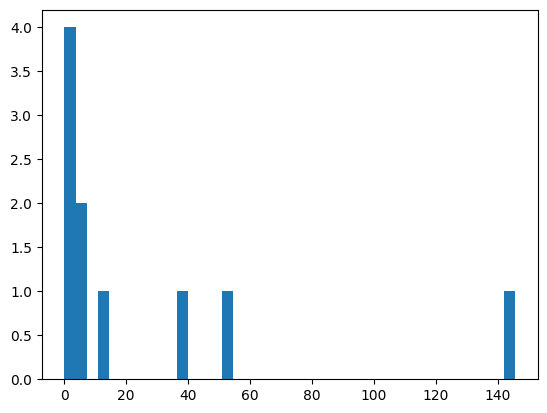

In [671]:
# Plot the trip distances in a histogram
plt.hist(aggregator.assigned_trips_dataframe()['trip_length'], bins=40)
plt.show()

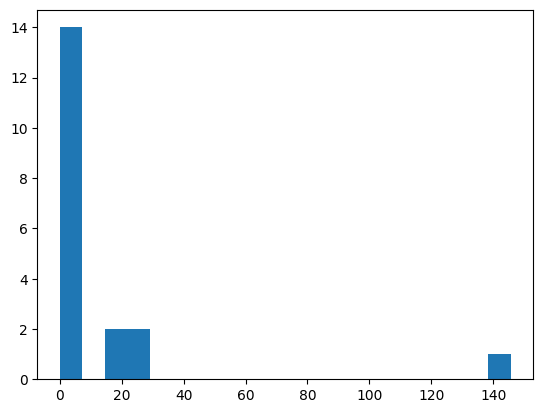

In [672]:
# Plot the segment distances in a histogram
plt.hist(aggregator.assigned_segments_dataframe()['trip_length'], bins=20)
plt.show()

In [627]:
aggregator.assigned_trips_dataframe()['trip_length'].mean()

33.947